In [8]:
# ! pip install pytesseract
# ! pip install pdf2image
! pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 16.8 MB/s eta 0:00:00a 0:00:01


In [1]:
def load_pdf(pdf_path):
    return {"pdf_path": pdf_path}

In [2]:
def classify_document(pdf_path):
    import fitz  # PyMuPDF
    doc = fitz.open(pdf_path)
    page = doc[0]
    text = page.get_text()
    if len(text.strip()) < 10:
        return {"document_type": "non-digital"}
    return {"document_type": "digital"}


In [9]:
from pytesseract import image_to_string
from pdf2image import convert_from_path
import fitz  # for digital

def extract_text(pdf_path, document_type):
    if document_type == "non-digital":
        images = convert_from_path(pdf_path)
        full_text = ""
        for img in images:
            full_text += image_to_string(img)
    else:
        doc = fitz.open(pdf_path)
        full_text = "\n".join([page.get_text() for page in doc])
    
    return {"extracted_text": full_text}


In [11]:
from openai import OpenAI

def extract_general_details(text):
    prompt = f"""Extract the following details from the document text:
    - Document Type
    - Name (if available)
    - Date
    - Organization
    - Any IDs

    Document:
    \"\"\"{text[:4000]}\"\"\"

    Answer in JSON format."""
    
    
    client = OpenAI(
        base_url = 'http://localhost:11434/v1',
        api_key='ollama', # required, but unused
    )

    response = client.chat.completions.create(
    model="llama3.2",
        messages=[{"role": "user", "content": prompt}]
    )
    return {"document_summary": response['choices'][0]['message']['content']}


In [12]:
# from openai import OpenAI

# client = OpenAI(
#     base_url = 'http://localhost:11434/v1',
#     api_key='ollama', # required, but unused
# )

# response = client.chat.completions.create(
#   model="llama3.2",
#   messages=[
#     {"role": "system", "content": "You are a helpful assistant."},
#     {"role": "user", "content": "Who won the world series in 2020?"},
#     {"role": "assistant", "content": "The LA Dodgers won in 2020."},
#     {"role": "user", "content": "Where was it played?"}
#   ]
# )
# print(response.choices[0].message.content)

In [13]:
def format_output(original_text, extracted_details):
    return {
        "summary": extracted_details,
        "raw_text": original_text
    }


In [15]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


# graph_builder = StateGraph(State)
graph = StateGraph(State)

graph.add_node("Load PDF", load_pdf)
graph.add_node("Classify", classify_document)
graph.add_node("Extract Text", extract_text)
graph.add_node("Extract Details", extract_general_details)
graph.add_node("Final Output", format_output)

graph.set_entry_point("Load PDF")

graph.add_edge("Load PDF", "Classify")
graph.add_edge("Classify", "Extract Text")
graph.add_edge("Extract Text", "Extract Details")
graph.add_edge("Extract Details", "Final Output")

graph.set_finish_point("Final Output")


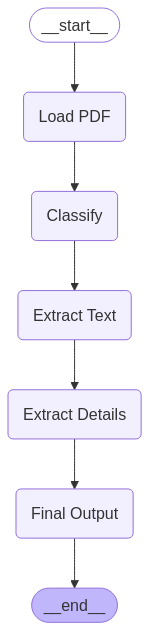

In [18]:
from IPython.display import Image, display
graph2 = graph.compile()

try:
    display(Image(graph2.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Error",e)
    # This requires some extra dependencies and is optional
    pass